# Recurrent Neural Networks for Forex prediction

### Imports

In [1]:
import os
import time
import warnings
import math

import numpy as np
import pandas as pd
from scipy.stats import describe as describe_st

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

### Display options

In [15]:
plt.style.use('default')
pd.set_option("display.max_rows", 20)

## Data

In [5]:
dataset_raw = pd.read_csv('data/exchange_rates_FED.csv', header=3, index_col=0).iloc[2:,:]
dataset_raw = dataset_raw.add_prefix('USD/')
dataset_raw = dataset_raw.rename(index=str, columns={"USD/USD":"EUR/USD", "USD/USD.1":"GBP/USD", "USD/USD.2":"AUD/USD", "USD/USD.3":"NZD/USD",
                                            "USD/Unnamed: 19":"NBDI", "USD/Unnamed: 20":"NMCDI", "USD/Unnamed: 21":"NOITPI"})

dates = dataset_raw.index  # save index

In [6]:
# to numeric
prices = pd.DataFrame(columns=dataset_raw.columns)
for col in prices.columns:
    prices[col] = pd.to_numeric(dataset_raw[col].astype(str), errors="coerce")

### Dataset overview
- 12170 rows (days)
    - start date: January 4, 1971
    - end date: August 25, 2017
- 26 columns (23 currencies vs. USD, plus 3 indices*)
    - series of different length, rest NaN
    - e.g. EUR/USD starts in 1999
    - most other main currency pairs in 1971

    *(Nominal Broad Dollar Index, Nominal Major Currencies Dollar Index, Nominal Other Important Trading Partners Dollar Index)

#### Returns

- create a separate dataframe for daily returns
- skip `NaN`s instead of padding them with zeroes - that would mislead the models with artificial data

In [7]:
returns = pd.DataFrame(index=prices.index, columns=prices.columns)

for col in returns.columns:
    returns[col] = prices[col][prices[col].notnull()].pct_change()

#### Select currency pairs

In [8]:
currencies = ["EUR/USD", "GBP/USD", "USD/JPY", "USD/CHF"]

#### Plot time series

D:\Miniconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


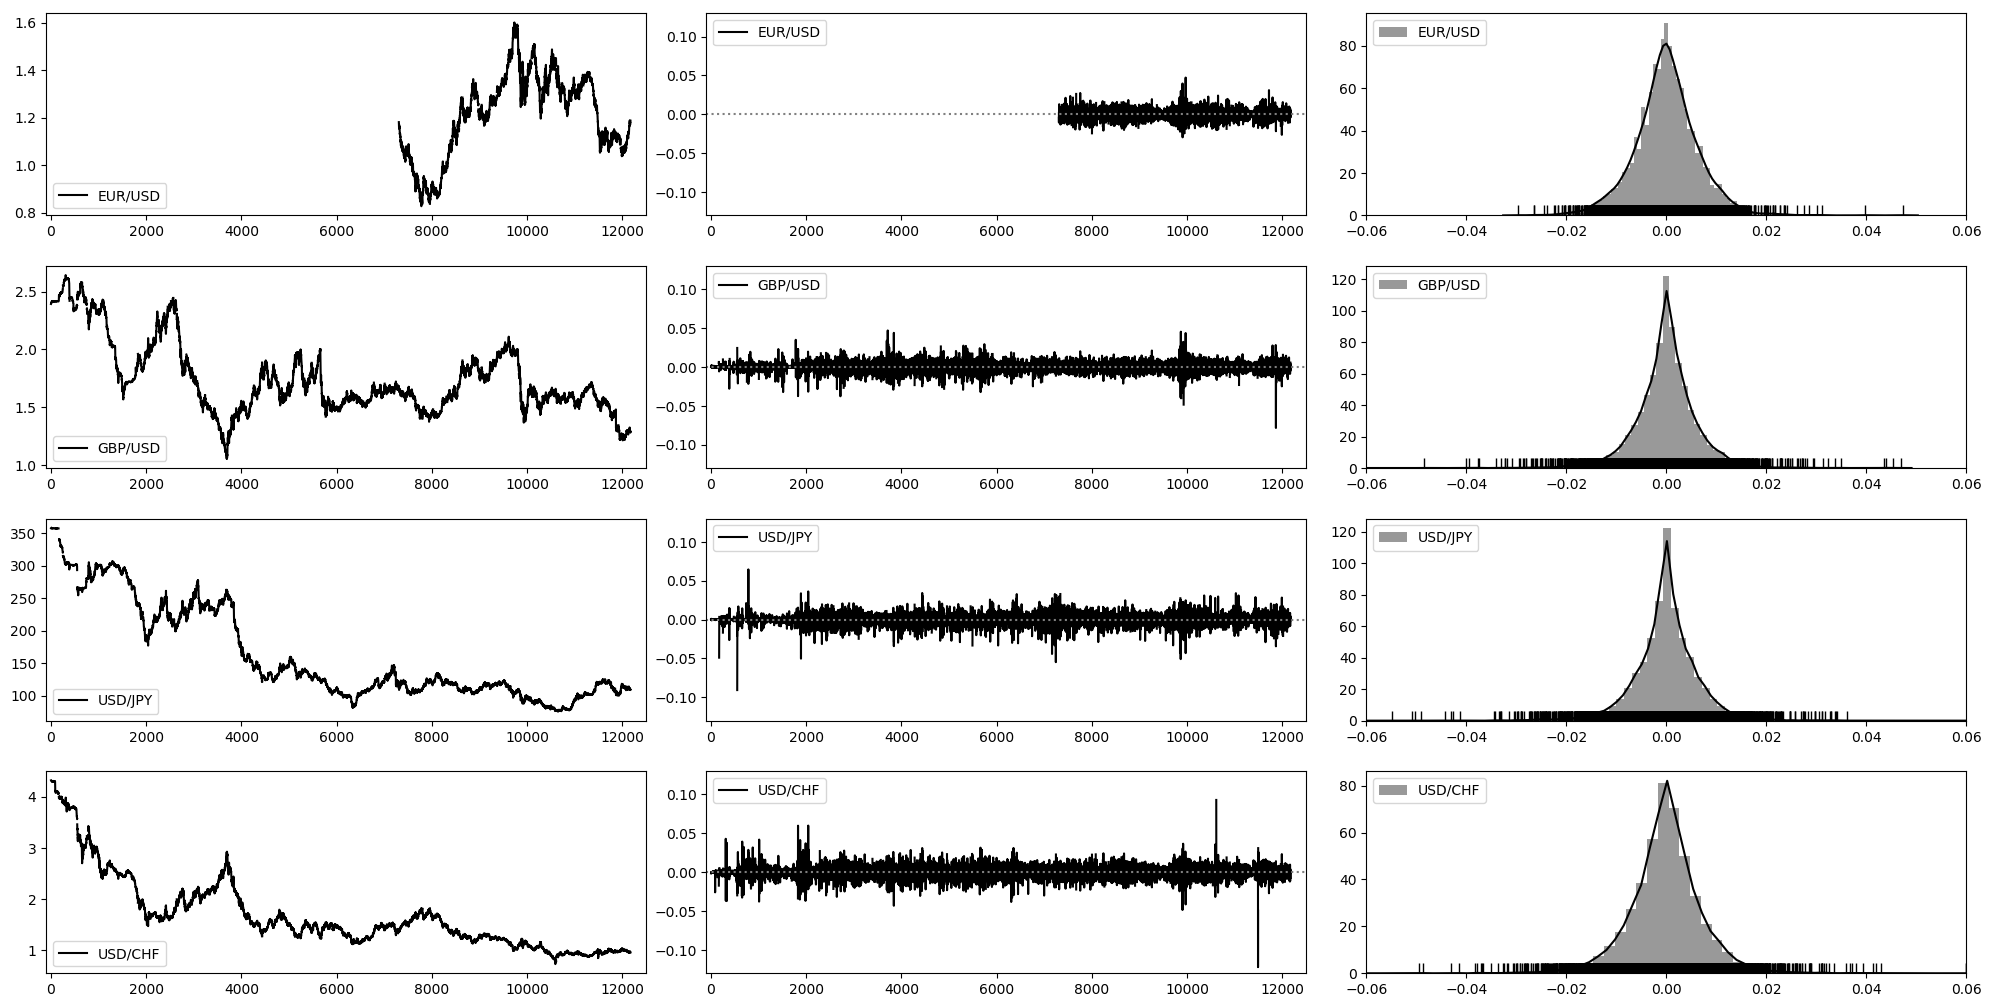

In [11]:
subplot_no = 1
plt.figure(1)

for curr in currencies:
    
    # plot prices
    plt.subplot(len(currencies), 3, subplot_no)
    plt.plot(prices[curr].values, color='black', label=curr)
    plt.legend(loc='lower left')
    plt.xlim(-100, 12500)
#     plt.grid(True)
    subplot_no += 1
    
    # plot returns
    plt.subplot(len(currencies), 3, subplot_no)
    plt.plot(returns[curr].values, color='black', label=curr)
    plt.axhline(0, color='gray', linestyle=':')
    plt.legend(loc='upper left')
    plt.xlim(-100, 12500)
    plt.ylim(-0.13, 0.13)
#     plt.grid(True)
    subplot_no += 1
    
    # plot returns
    plt.subplot(len(currencies), 3, subplot_no)
    sns.distplot(returns[curr][returns[curr].notnull()].values, #kde=False,
                 bins=100, color='black', label=curr, rug=True)
#     plt.axvline(0, color='gray', linestyle=':')
    plt.legend(loc='upper left')
#     plt.xlim(-0.1, 0.1)
    plt.xlim(-0.06, 0.06)
#     plt.ylim(-0.1, 0.1)
#     plt.grid(True)
    subplot_no += 1
    

plt.subplots_adjust(top=1, bottom=-1, left=0, right=3, hspace=0.25, wspace=0.1)

plt.savefig('plots/time_series.png', bbox_inches='tight', transparent=True)

## Summary

In [16]:
describe_prices = prices[currencies].describe()

In [17]:
describe_returns = returns[currencies].describe()
describe_returns.loc['skewness'] = returns[currencies].skew()
describe_returns.loc['kurtosis'] = returns[currencies].kurt()

In [18]:
describe_prices

,EUR/USD,GBP/USD,USD/JPY,USD/CHF
count,4688.000000,11709.000000,11703.000000,11709.000000
mean,1.208703,1.744384,161.672535,1.682665
std,0.174480,0.312975,73.461780,0.729848
min,0.827000,1.052000,75.720000,0.729600
25%,1.084700,1.540000,108.140000,1.205900
50%,1.237650,1.646900,124.240000,1.486000
75%,1.337725,1.884000,227.025000,1.937000
max,1.601000,2.644000,358.440000,4.318000


In [19]:
describe_returns

,EUR/USD,GBP/USD,USD/JPY,USD/CHF
count,4687.000000,11708.000000,11702.000000,11708.000000
mean,0.000021,-0.000035,-0.000080,-0.000102
std,0.006291,0.005989,0.006488,0.007272
min,-0.029585,-0.078446,-0.090670,-0.122100
25%,-0.003446,-0.002920,-0.002981,-0.003754
50%,0.000000,0.000052,0.000000,0.000000
75%,0.003537,0.002929,0.003080,0.003593
max,0.047292,0.046954,0.064554,0.092979
skewness,0.151108,-0.321630,-0.554028,-0.230477
kurtosis,2.259082,6.951420,8.612827,12.369660


In [21]:
describe_returns.to_csv('data/describe_returns.csv')

describe_returns.round(4).to_latex(escape=False)